In [1]:
%load_ext autoreload
%autoreload 2
print("HERE")
from tenkllsorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import os
import cv2
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
print(tf.config.list_physical_devices())
from tensorflow.python.client import device_lib

from sklearn import preprocessing

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")


HERE
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


In [2]:

def load_img(img_path,img_shape, preprocess=True):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path, target_size=(img_rows, img_cols))    
    if preprocess:
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

        img =  preprocess_input(img)
        return img

    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return np.array(img, dtype=np.uint8)

In [3]:
def lap_mag(channels):
    laps = []
    print(channels.shape)
    for i in range(channels.shape[-1]):
        
        dst = cv2.Laplacian(channels[:,:,i], cv2.CV_32F , 3)
        laps.append(dst)
    mag = np.linalg.norm(laps, axis = 0)
    return mag

In [4]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(None, None, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

In [6]:
def local_arg_exrtrema_3(mat1, mat2, mat3):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat1.shape[0]-1):
        for j in range(1, mat1.shape[1]-1):
            pixel_of_interest = mat2[i,j]
            #if np.abs(pixel_of_interest)>2000:
            #print(pixel_of_interest)
            neighbours = mat2[i-1:i+2, j-1:j+2]
            #neighbours[1,1] = np.NaN  #make center nan
            neighbours_above = mat3[i-1:i+2, j-1:j+2]
            neighbours_below = mat1[i-1:i+2, j-1:j+2]
            
            if (pixel_of_interest >= np.max(neighbours) and pixel_of_interest >= np.max(neighbours_above) and pixel_of_interest >= np.max(neighbours_below)) or (pixel_of_interest <= np.min(neighbours) and pixel_of_interest <= np.min(neighbours_above) and  pixel_of_interest <= np.min(neighbours_below)):
                idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)

def local_arg_exrtrema_1(mat):

    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    for i in range(1, mat.shape[0]-1):
        for j in range(1, mat.shape[1]-1):
            pixel_of_interest = mat[i,j]
            neighbours = mat[i-1:i+2, j-1:j+2]
            
            if (pixel_of_interest >= np.max(neighbours)) or (pixel_of_interest <= np.min(neighbours)):
                idx.append(np.array([j,i]))

    return np.unique(idx, axis=0)   

def local_arg_max(mat, window_size):
    #Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
    idx = []

    k = int(np.floor(window_size/2))
    print(k)
    for i in range(k, mat.shape[0]-k, window_size):
        for j in range(k, mat.shape[1]-k, window_size):

            window = mat[i-k:i+k+1, j-k:j+k+1]
            coords = np.argwhere(window==window.max())
            
            idx.extend(coords + [i-k, j-k])

    return  np.unique(idx, axis=0)   



In [7]:
x = np.array([[1,2,3,75,3,2,1,5,45], [5,7,8,5,11,21,81,6,1] , [3,4,5,43,53,3,9,3,4], [6,34,3,21,3,4,32,3,1], [45,344,2,43,2541,38,3,34,32] , [23,74,343,4,31,97,8, 34,22], [9,7,3,6,4,3,7,2,1]])
x
#np.reshape(x, [-1,4])

array([[   1,    2,    3,   75,    3,    2,    1,    5,   45],
       [   5,    7,    8,    5,   11,   21,   81,    6,    1],
       [   3,    4,    5,   43,   53,    3,    9,    3,    4],
       [   6,   34,    3,   21,    3,    4,   32,    3,    1],
       [  45,  344,    2,   43, 2541,   38,    3,   34,   32],
       [  23,   74,  343,    4,   31,   97,    8,   34,   22],
       [   9,    7,    3,    6,    4,    3,    7,    2,    1]])

In [8]:
local_arg_max(x, 4)

2


array([[4, 4]], dtype=int64)

In [9]:

data_path1= './SYS809_projet2022_sequences1/legumesA-02.jpg'  #'./SYS809_projet2022_sequences1/livre1_old.JPG'
data_path2=  './SYS809_projet2022_sequences1/legumesB-02.jpg'

data_path1= './SYS809_projet2022_sequences1/new_livre1.jpg' #'./SYS809_projet2022_sequences1/new_livre1.JPG'
data_path2='./SYS809_projet2022_sequences1/livre2.jpg' # './SYS809_projet2022_sequences1/livre2.JPG'

img = load_img(data_path1, [224,224])
img_no_proc = load_img(data_path1, [224,224], preprocess=False)





In [10]:
(2**3) #// 2

8

3 3
0.0 0.0
3 11
0.0 1.0
3 19
0.0 2.0
3 27
0.0 3.0
3 35
0.0 4.0
3 43
0.0 5.0
3 51
0.0 6.0
3 59
0.0 7.0
3 67
0.0 8.0
3 75
0.0 9.0
3 83
0.0 10.0
3 91
0.0 11.0
3 99
0.0 12.0
3 107
0.0 13.0
3 115
0.0 14.0
3 123
0.0 15.0
3 131
0.0 16.0
3 139
0.0 17.0
3 147
0.0 18.0
3 155
0.0 19.0
3 163
0.0 20.0
3 171
0.0 21.0
3 179
0.0 22.0
3 187
0.0 23.0
3 195
0.0 24.0
3 203
0.0 25.0
3 211
0.0 26.0
3 219
0.0 27.0
11 3
1.0 0.0
11 11
1.0 1.0
11 19
1.0 2.0
11 27
1.0 3.0
11 35
1.0 4.0
11 43
1.0 5.0
11 51
1.0 6.0
11 59
1.0 7.0
11 67
1.0 8.0
11 75
1.0 9.0
11 83
1.0 10.0
11 91
1.0 11.0
11 99
1.0 12.0
11 107
1.0 13.0
11 115
1.0 14.0
11 123
1.0 15.0
11 131
1.0 16.0
11 139
1.0 17.0
11 147
1.0 18.0
11 155
1.0 19.0
11 163
1.0 20.0
11 171
1.0 21.0
11 179
1.0 22.0
11 187
1.0 23.0
11 195
1.0 24.0
11 203
1.0 25.0
11 211
1.0 26.0
11 219
1.0 27.0
19 3
2.0 0.0
19 11
2.0 1.0
19 19
2.0 2.0
19 27
2.0 3.0
19 35
2.0 4.0
19 43
2.0 5.0
19 51
2.0 6.0
19 59
2.0 7.0
19 67
2.0 8.0
19 75
2.0 9.0
19 83
2.0 10.0
19 91
2.0 11.0
19 99
2.0 1

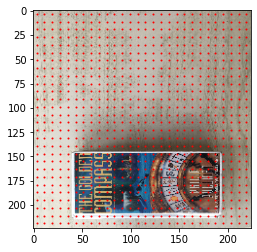

In [24]:
#img = load_img(data_path1,[224,224], preprocess=False)

pool_layers = [3,4,5]

layer_pool_1 = np.stack(get_cnn_out(img, 3))
layer_pool_2 = np.stack(get_cnn_out(img, 6)) 
layer_pool_3 = np.stack(get_cnn_out(img, 10)) 
layer_pool_4 = np.stack(get_cnn_out(img, 14))
layer_pool_5 = np.stack(get_cnn_out(img, 18))

layers = [layer_pool_1,layer_pool_2,layer_pool_3,layer_pool_4,layer_pool_5]

kps=[]
d = []
kp_desc = dict()
#Use a moving window to find local max/min in section. Determine coordinate of max pixel in image.
idx = []

for i in range(3, img[0].shape[0]-4, 8):
    for j in range(3, img[0].shape[1]-4, 8):
        print(i,j)
        #window = img[i-k:i+k+1, j-k:j+k+1]
        #coords = np.argwhere(window==window.max())
        row = i# ((i+.5)) * (2**l) 
        col = j #((j+.5)) * (2**l) 
        #d = layers[l-1][ i, j, : ]
        keypoint = cv2.KeyPoint()
        keypoint.pt = (float(row), float(col))
        keypoint.octave = 0
        keypoint.size = 0
        keypoint.response = 0
        kps.append(keypoint)
        print(np.floor(i/8), np.floor(j/8))
        d_vec_3 = layer_pool_3[ int(np.floor(i/8)), int(np.floor(j/8)), : ].flatten()
        d_vec_3 = np.abs(d_vec_3)
        d_vec_3 = np.abs(d_vec_3)

        d_vec_4 = layer_pool_4[ int(np.floor(i/16)), int(np.floor(j/16)), : ].flatten()
        d_vec_4 = np.abs(d_vec_4)
        d_vec_4 = np.abs(d_vec_4)

        d_vec_5 = layer_pool_5[ int(np.floor(i/32)), int(np.floor(j/32)), : ].flatten()
        d_vec_5 = np.abs(d_vec_5)
        d_vec_5 = np.abs(d_vec_5)

        d.append(np.concatenate([d_vec_3, d_vec_4, d_vec_5]))


img1_pts = np.float32([ kp.pt for kp in kps])
plt.figure()
plt.imshow(img_no_proc)
plt.scatter(list(list(zip(*img1_pts))[0]), list(list(zip(*img1_pts))[1]), s=[1], c='r')


In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img,None)

#Le champ .pt des object KeyPoint contiennent la position du point-cle

plt.imshow(cv2.drawKeypoints(img,kp1,None))

In [21]:
layer_pool_3.shape

(28, 28, 256)